<h2> Задача: </h2>

Решить уравнение Лапласа в прямоугольнике $\left[ 0 , 4\right] \times  \left[ 0 , 2\right]$

$
\begin{cases}
   \Delta \varphi (x, y)  = 0, \\
   \varphi (x, 2) = \varphi (0, y) = \varphi (4, y) = 0, \\
   \varphi (x, 0) = 10.
\end{cases}
$


Точное решение:

$
\displaystyle
\varphi\left(x, y\right) = \sum_{n = 1}^{\infty} \dfrac{20 \left(1 - (-1)^n \right)}{\pi n \left[ exp\left({-\dfrac{\pi n}{2}}\right) - exp\left({\dfrac{\pi n}{2}}\right)  \right]} \left[ exp\left({-\dfrac{\pi n}{4}} (2 - y) \right) -  exp\left({\dfrac{\pi n}{4}} (2 - y) \right)  \right] \sin{\left( \dfrac{\pi n}{4} x \right)}
$

In [3]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pandas as pd
import numpy as np
from numba import njit
import time

export_path = "./latex/illustr/domain_rectangle_dirichlet_only/"
# plots a finite element mesh
def plot_fem_mesh(nodes_x, nodes_y, elements, linewidth: float = 0.2):
    # print(nodes_x)
    it = 0
    for element in elements:
        x = [nodes_x[element[0]], nodes_x[element[1]], nodes_x[element[2]]]
        y = [nodes_y[element[0]], nodes_y[element[1]], nodes_y[element[2]]]
        # print(x , y)
        plt.fill(x, y, edgecolor='black', linewidth = linewidth, fill=False)
        it += 1

@njit()
def mean_square(coords, polygons):
    
    S_el = lambda poly: ((coords[poly[1]][0] - coords[poly[0]][0]) * (coords[poly[2]][1] - coords[poly[0]][1]) - (coords[poly[2]][0] - coords[poly[0]][0]) * (coords[poly[1]][1] - coords[poly[0]][1])) / 2
    res = 0.
    for el in polygons:
        res += S_el(el)
    return round(res / len(polygons), 8)

@njit()
def max_square(coords, polygons):
    
    S_el = lambda poly: ((coords[poly[1]][0] - coords[poly[0]][0]) * (coords[poly[2]][1] - coords[poly[0]][1]) - (coords[poly[2]][0] - coords[poly[0]][0]) * (coords[poly[1]][1] - coords[poly[0]][1])) / 2
    S_max = 0.
    tmp = 0.
    for el in polygons:
        tmp = S_el(el)
        if (tmp > S_max):
            S_max = tmp
    return round(S_max, 8)

# @njit()
# def exact_solution(x, y, row_num_el: int = 350):
#     res = 0
#     for n in range(1, row_num_el + 1):
#         if n % 2 != 0:
#             res += 20 * (1 - (-1) ** n) / (np.pi * n) / (np.exp(- np.pi * n / 2 ) - np.exp( np.pi * n / 2 )) * (np.exp(- np.pi * n / 4 * y ) - np.exp( np.pi * n / 4 * y)) * np.sin(np.pi * n / 4 * x)
#     if np.fabs(res) < 1e-15:
#         return 0.
#     return res

@njit()
def exact_solution(x, y, row_num_el: int = 350):
    res = 0
    for n in range(1, row_num_el + 1):
        if n % 2 != 0:
            res += 20 * (1 - (-1) ** n) / (np.pi * n) / (np.exp(- np.pi * n / 2 ) - np.exp( np.pi * n / 2 )) * (np.exp(- np.pi * n / 4 * (2 - y) ) - np.exp( np.pi * n / 4 * (2 - y))) * np.sin(np.pi * n / 4 * x)
    if np.fabs(res) < 1e-15:
        return 0.
    return res

def print_error(x, y, z):
    error_in_node = [];
    for i in range(len(z)):
        error_in_node.append( np.fabs( z[i] - exact_solution(x[i], y[i]) ))

    mean_err = round(np.mean(error_in_node), 4)
    print("Mean error: ", mean_err)

    ind_max = np.argmax(error_in_node)
    print("Max error: ", round(np.max(error_in_node), 4),  f"point: ({round(x[ind_max], 4)}, {round(y[ind_max], 4)})" )
    
    nodes_with_high_err = np.where(error_in_node > mean_err * 1.25)[0]
    # print(nodes_with_high_err)
    coords_with_high_err = []
    
    for j in nodes_with_high_err:
        coords_with_high_err.append([x[j], y[j]])
    coords_with_high_err = np.array(coords_with_high_err).T
    # print(coords_with_high_err)
    return coords_with_high_err

    # for i in range(len(error_in_node)):
    #     if error_in_node[i] > 0.2:
    #         print( x[i], y[i], error_in_node[i])



def print_mean_rel_error(x, y ,z):
    error_in_node = [];
    for i in range(len(z)):
        z_exact = exact_solution(x[i], y[i])
        if np.fabs(z_exact) > 1e-9:
            error_in_node.append( np.divide(np.fabs( z[i] - z_exact ) , z_exact) )
    print("Mean rel error: ", round(np.mean(error_in_node), 8))




@njit
def L2_error_njit(coords, polygons, solution):
    res = 0.

    S_el = lambda poly: ((coords[poly[1]][0] - coords[poly[0]][0]) * (coords[poly[2]][1] - coords[poly[0]][1]) - (coords[poly[2]][0] - coords[poly[0]][0]) * (coords[poly[1]][1] - coords[poly[0]][1])) / 2
    error_in_node = [];
    for poly in polygons:
        Si = S_el(poly)    
        tmp = 0.
        for j in range(3):
            tmp += (exact_solution(coords[poly[j]][0], coords[poly[j]][1]) - solution[poly[j]]) ** 2
        res += Si * tmp / 3
        # res += tmp / 3

    return res

def L2_error(coords, polygons, solution):
    res = L2_error_njit(coords, polygons, solution)
    print(f"L2_error S: {round(res, 8)}")
    pass



<h1> True sol

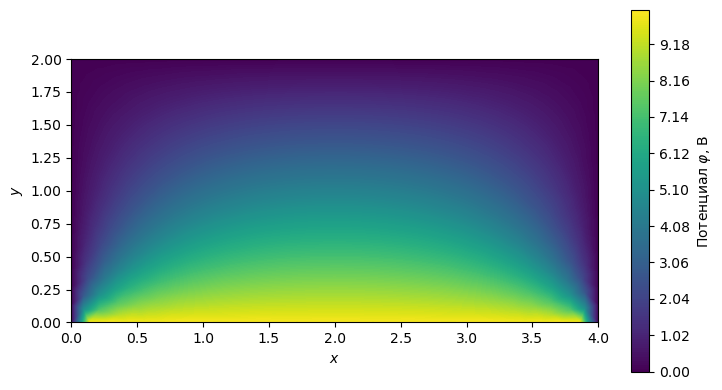

In [4]:
df_x_y = pd.read_csv("./domains/domain_2/mesh001/mesh_nodes.csv")
df_z_exact = pd.read_csv("./output/domain_2_extra/mesh001/Test_domain_2_rectangle_dirichlet_only_001_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh001/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;
for i in range(len(df_z_exact["sol"].values)):
    df_z_exact["sol"].values[i] = exact_solution(df_x_y["x"].values[i], df_x_y["y"].values[i])


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z_exact["sol"].values, levels = 200)

#plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)

plt.axis("image")
plt.colorbar(label = "Потенциал $\\varphi$, В" )
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig(export_path + "rect_dirichlet_only_exact_sol.png", dpi = 500, transparent=True)
plt.show()


<h2> Численное решение </h2>

<h1> Rectangle domain (normal cell 0.05)


        \hline
        40
        & 1.36618892
        & 1.33598302 
        & 0.0302059
        & 0.02210961 \\ 
    

        \hline
        60
        & 4.27941666
        & 4.25785442 
        & 0.02156224
        & 0.00503859 \\ 
    

        \hline
        80
        & 4.66579937
        & 4.61842309 
        & 0.04737628
        & 0.01015395 \\ 
    

        \hline
        100
        & 5.85030507
        & 5.83214137 
        & 0.0181637
        & 0.00310474 \\ 
    

        \hline
        120
        & 7.14850872
        & 7.13828397 
        & 0.01022475
        & 0.00143033 \\ 
    
Number of nodes:  129
Number of elements:  216
Mean S:  0.03703704
Max S:  0.045456
Mean rel error:  0.01107619
Mean error:  0.0301
Max error:  0.7292 point: (3.7884, 0.205)
L2_error S: 0.06598977


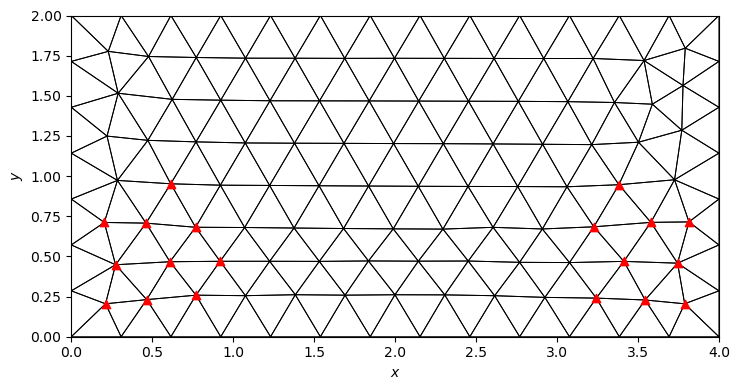

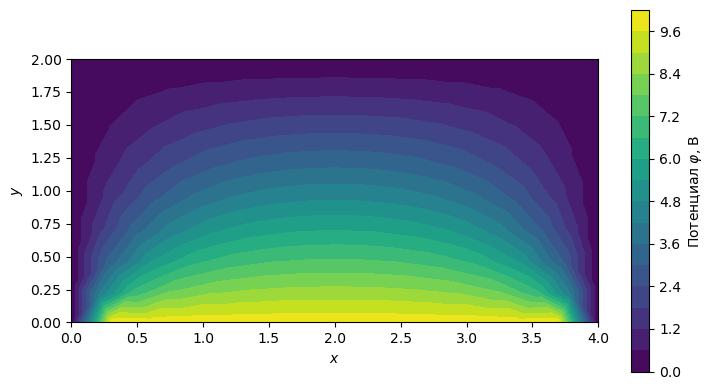

In [8]:
domain_name = "rect_dirichlet_only_005_calfem"

df_x_y = pd.read_csv("./domains/domain_2/mesh005_calfem/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh005_calfem/Test_domain_2_rectangle_dirichlet_only_005_rev_calfem_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh005_calfem/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;


def pr_er(k):
    z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
    #print( round(df_x_y["x"].values[k], 8),  round(df_x_y["y"].values[k], 8))
    print(f"""
        \\hline
        {k}
        & {round(z_exact, 8)}
        & {round(df_z["sol"].values[k], 8)} 
        & {round(np.fabs(z_exact - df_z["sol"].values[k]) , 8)}
        & {round(np.fabs(z_exact - df_z["sol"].values[k]) / z_exact, 8)} \\\\ 
    """)


k = 40
pr_er(k)

k = 60
pr_er(k)

k = 80
pr_er(k)

k = 100
pr_er(k)

k = 120
pr_er(k)

print("Number of nodes: ", len(df_x_y.values))
print("Number of elements: ", len(df_elements.values))
print("Mean S: ", mean_square(df_x_y.values, df_elements.values) )
print("Max S: ", max_square(df_x_y.values, df_elements.values) )


print_mean_rel_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
coords_with_high_err = print_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
L2_error(df_x_y.values, df_elements.values, df_z["sol"].values)


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values, 0.7)
plt.scatter(coords_with_high_err[0], coords_with_high_err[1], marker="^", color="red")
plt.axis([0, 4, 0, 2])

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig(export_path + domain_name + "_net.pdf", transparent=False)
plt.show()
plt.close()



plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z["sol"].values, levels = 17)


plt.axis("image")
plt.colorbar(label = "Потенциал $\\varphi$, В" )
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig(export_path + domain_name + ".png", dpi = 300, transparent=True)
plt.show()


<h1> Rectangle domain (cell 0.05) calfem


        \hline
        40
        & 1.27392652
        & 1.25634191 
        & 0.01758461
        & 0.01380348 \\ 
    

        \hline
        60
        & 3.72330814
        & 3.70649274 
        & 0.0168154
        & 0.00451625 \\ 
    

        \hline
        80
        & 1.95722711
        & 1.93729186 
        & 0.01993525
        & 0.01018546 \\ 
    

        \hline
        100
        & 2.69063261
        & 2.68065981 
        & 0.0099728
        & 0.00370649 \\ 
    

        \hline
        120
        & 1.9138927
        & 1.90537176 
        & 0.00852094
        & 0.00445215 \\ 
    
Mean rel error:  0.01087074
Mean error:  0.0289
Max error:  0.6628 point: (3.7919, 1.7962)
L2_error S: 0.05392223


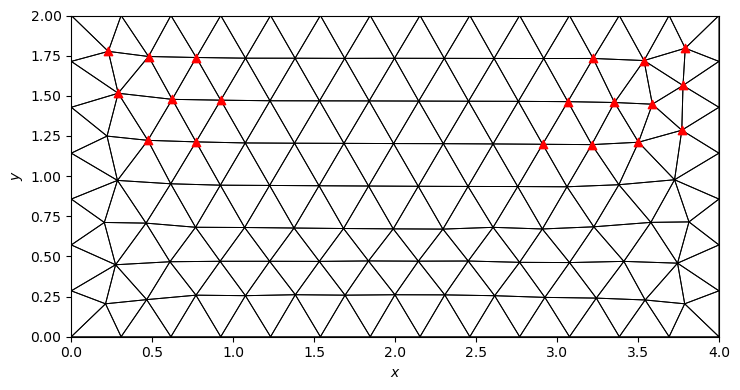

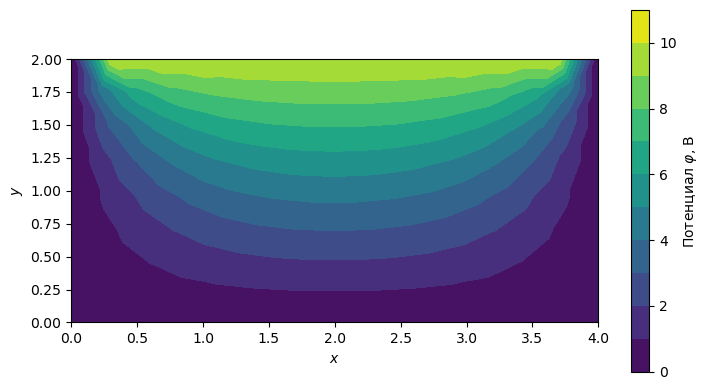

In [42]:
domain_name = "rect_dirichlet_only_005_calfem"

df_x_y = pd.read_csv("./domains/domain_2/mesh005_calfem/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh005_calfem/Test_domain_2_rectangle_dirichlet_only_005_calfem_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh005_calfem/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;


def pr_er(k):
    z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
    #print( round(df_x_y["x"].values[k], 8),  round(df_x_y["y"].values[k], 8))
    print(f"""
        \\hline
        {k}
        & {round(z_exact, 8)}
        & {round(df_z["sol"].values[k], 8)} 
        & {round(np.fabs(z_exact - df_z["sol"].values[k]) , 8)}
        & {round(np.fabs(z_exact - df_z["sol"].values[k]) / z_exact, 8)} \\\\ 
    """)
    pass


k = 40
pr_er(k)

k = 60
pr_er(k)

k = 80
pr_er(k)

k = 100
pr_er(k)

k = 120
pr_er(k)

print_mean_rel_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
coords_with_high_err = print_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
L2_error(df_x_y.values, df_elements.values, df_z["sol"].values)


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values, 0.7)
plt.scatter(coords_with_high_err[0], coords_with_high_err[1], marker="^", color="red")
plt.axis([0, 4, 0, 2])
# plt.axis('off')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig(export_path + domain_name + "_net.pdf", transparent=False)
plt.show()
plt.close()



plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z["sol"].values, levels = 10)
#plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values, 0.7)


plt.axis("image")
plt.colorbar(label = "Потенциал $\\varphi$, В" )
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig(export_path + domain_name + ".png", dpi = 300, transparent=True)
plt.show()


<h1> Rectangle domain (small cell 0.01)


        \hline
        100
        & 0.92024967
        & 0.91207042 
        & 0.00817925
        & 0.00888808 \\ 
    

        \hline
        200
        & 0.37867336
        & 0.38007247 
        & 0.00139911
        & 0.00369477 \\ 
    

        \hline
        300
        & 2.37307293
        & 2.36495291 
        & 0.00812002
        & 0.00342173 \\ 
    

        \hline
        400
        & 1.03698103
        & 1.03342861 
        & 0.00355242
        & 0.00342573 \\ 
    
Number of nodes:  655
Number of elements:  1222
Mean S:  0.00654664
Max S:  0.00998175
Mean rel error:  0.00301047
Mean error:  0.0082
Max error:  0.7245 point: (3.9022, 1.9051)
L2_error S: 0.01298109


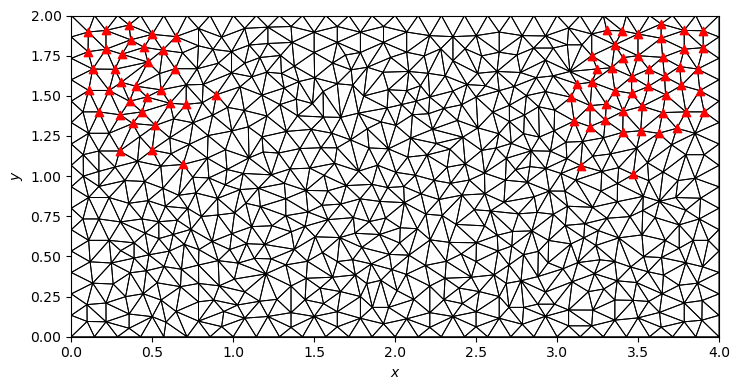

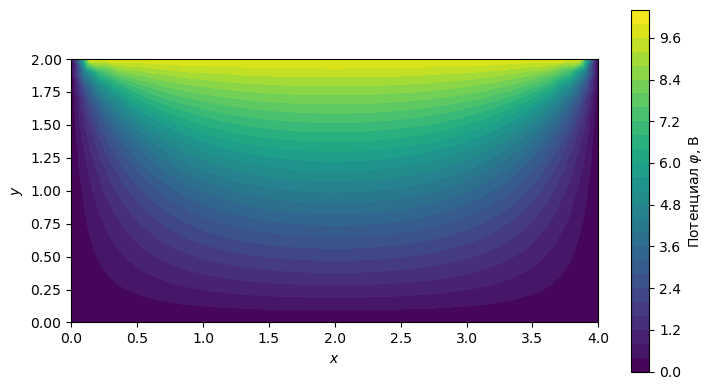

In [43]:
domain_name = "rect_dirichlet_only_001"

df_x_y = pd.read_csv("./domains/domain_2/mesh001/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh001/Test_domain_2_rectangle_dirichlet_only_001_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh001/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;


def pr_er(k):
    z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
    #print( round(df_x_y["x"].values[k], 8),  round(df_x_y["y"].values[k], 8))
    print(f"""
        \\hline
        {k}
        & {round(z_exact, 8)}
        & {round(df_z["sol"].values[k], 8)} 
        & {round(np.fabs(z_exact - df_z["sol"].values[k]) , 8)}
        & {round(np.fabs(z_exact - df_z["sol"].values[k]) / z_exact, 8)} \\\\ 
    """)

k = 100
pr_er(k)

k = 200
pr_er(k)

k = 300
pr_er(k)

k = 400
pr_er(k)

print("Number of nodes: ", len(df_x_y.values))
print("Number of elements: ", len(df_elements.values))
print("Mean S: ", mean_square(df_x_y.values, df_elements.values) )
print("Max S: ", max_square(df_x_y.values, df_elements.values) )


print_mean_rel_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
coords_with_high_err = print_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
L2_error(df_x_y.values, df_elements.values, df_z["sol"].values)


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values, 0.7)
plt.scatter(coords_with_high_err[0], coords_with_high_err[1], marker="^", color="red")
plt.axis([0, 4, 0, 2])
# plt.axis('off')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig(export_path + domain_name + "_net.pdf", transparent=False)
plt.show()
plt.close()

plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z["sol"].values, levels = 25)

#plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)
plt.axis("image")
plt.colorbar(label = "Потенциал $\\varphi$, В" )
plt.xlabel("$x$")
plt.ylabel("$y$")

plt.savefig(export_path + domain_name + ".png", dpi = 300, transparent=False)
plt.show()

<h1> Rectangle domain (cell 0.01) calfem


        \hline
        100
        & 8.79692038
        & 8.7754521 
        & 0.02146828
        & 0.00244043 \\ 
    

        \hline
        200
        & 4.20092245
        & 4.18212546 
        & 0.01879699
        & 0.00447449 \\ 
    

        \hline
        300
        & 1.26335365
        & 1.26129625 
        & 0.0020574
        & 0.00162853 \\ 
    

        \hline
        400
        & 2.55278075
        & 2.5283193 
        & 0.02446145
        & 0.00958228 \\ 
    

        \hline
        500
        & 2.88063844
        & 2.68968953 
        & 0.19094891
        & 0.06628701 \\ 
    
Number of nodes:  555
Number of elements:  1020
Mean S:  0.00784314
Max S:  0.00948165
Mean rel error:  0.00395515
Mean error:  0.0121
Max error:  0.6674 point: (0.1009, 1.9003)
L2_error S: 0.01467814


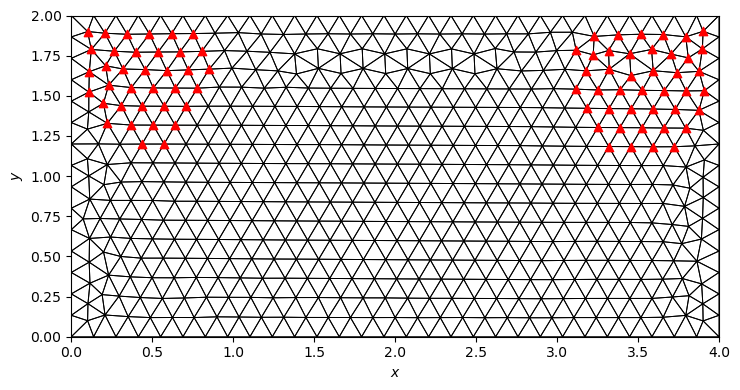

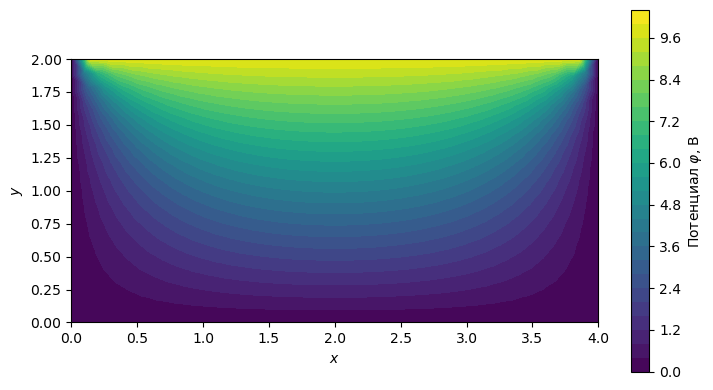

In [44]:
domain_name = "rect_dirichlet_only_001_calfem"

df_x_y = pd.read_csv("./domains/domain_2/mesh001_calfem/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh001_calfem/Test_domain_2_rectangle_dirichlet_only_001_calfem_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh001_calfem/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;


def pr_er(k):
    z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
    #print( round(df_x_y["x"].values[k], 8),  round(df_x_y["y"].values[k], 8))
    print(f"""
        \\hline
        {k}
        & {round(z_exact, 8)}
        & {round(df_z["sol"].values[k], 8)} 
        & {round(np.fabs(z_exact - df_z["sol"].values[k]) , 8)}
        & {round(np.fabs(z_exact - df_z["sol"].values[k]) / z_exact, 8)} \\\\ 
    """)

k = 100
pr_er(k)

k = 200
pr_er(k)

k = 300
pr_er(k)

k = 400
pr_er(k)

k = 500
pr_er(k)

print("Number of nodes: ", len(df_x_y.values))
print("Number of elements: ", len(df_elements.values))
print("Mean S: ", mean_square(df_x_y.values, df_elements.values) )
print("Max S: ", max_square(df_x_y.values, df_elements.values) )

print_mean_rel_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
coords_with_high_err = print_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
L2_error(df_x_y.values, df_elements.values, df_z["sol"].values)


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values, 0.7)
plt.scatter(coords_with_high_err[0], coords_with_high_err[1], marker="^", color="red")
plt.axis([0, 4, 0, 2])
# plt.axis('off')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig(export_path + domain_name + "_net.pdf", transparent=False)
plt.show()
plt.close()

plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z["sol"].values, levels = 25)

#plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)

plt.axis("image")
plt.colorbar(label = "Потенциал $\\varphi$, В" )
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig(export_path + domain_name + ".png", dpi = 300, transparent=False)
plt.show()

<h1> Rectangle domain (cell 0.005)


        \hline
        150
        & 0.23276813
        & 0.23302613 
        & 0.000258
        & 0.0011084 \\ 
    

        \hline
        200
        & 4.86222612
        & 4.86048743 
        & 0.00173869
        & 0.00035759 \\ 
    

        \hline
        300
        & 3.50380613
        & 3.49695751 
        & 0.00684862
        & 0.00195462 \\ 
    

        \hline
        400
        & 0.68805177
        & 0.68737132 
        & 0.00068045
        & 0.00098895 \\ 
    

        \hline
        500
        & 3.70321012
        & 3.7018705 
        & 0.00133962
        & 0.00036175 \\ 
    
Number of nodes:  998
Number of elements:  1874
Mean S:  0.00426894
Max S:  0.00553341
Mean rel error:  0.0015214
Mean error:  0.0044
Max error:  0.5381 point: (0.0732, 1.9268)
L2_error S: 0.00417991


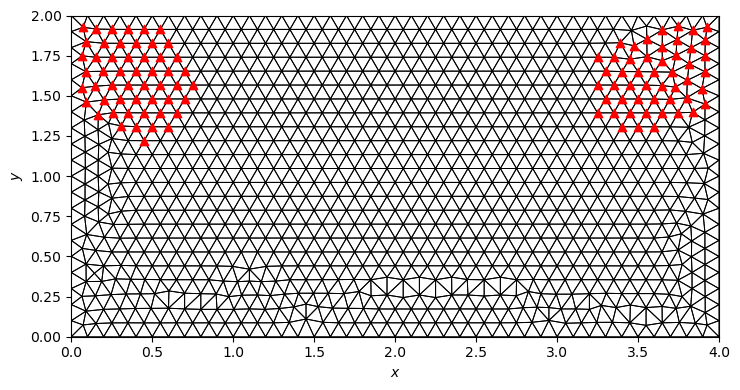

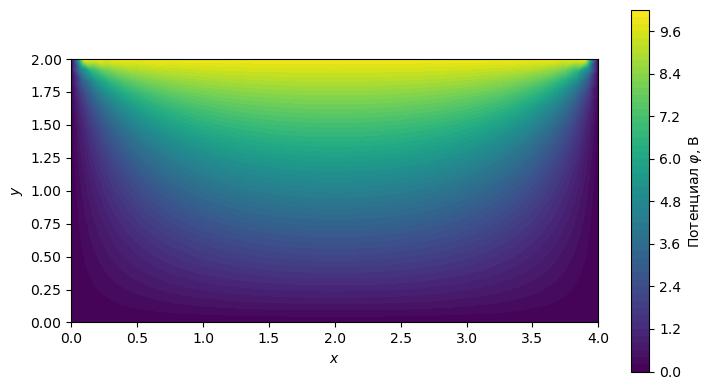

In [45]:
domain_name = "rect_dirichlet_only_0005_calfem"

df_x_y = pd.read_csv("./domains/domain_2/mesh0005_calfem/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh0005_calfem/Test_domain_2_rectangle_dirichlet_only_0005_calfem_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh0005_calfem/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;

def pr_er(k):
    z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
    #print( round(df_x_y["x"].values[k], 8),  round(df_x_y["y"].values[k], 8))
    print(f"""
        \\hline
        {k}
        & {round(z_exact, 8)}
        & {round(df_z["sol"].values[k], 8)} 
        & {round(np.fabs(z_exact - df_z["sol"].values[k]) , 8)}
        & {round(np.fabs(z_exact - df_z["sol"].values[k]) / z_exact, 8)} \\\\ 
    """)
    pass


k = 150
pr_er(k)

k = 200
pr_er(k)

k = 300
pr_er(k)

k = 400
pr_er(k)

k = 500
pr_er(k)


print("Number of nodes: ", len(df_x_y.values))
print("Number of elements: ", len(df_elements.values))
print("Mean S: ", mean_square(df_x_y.values, df_elements.values) )
print("Max S: ", max_square(df_x_y.values, df_elements.values) )


print_mean_rel_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
coords_with_high_err = print_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
L2_error(df_x_y.values, df_elements.values, df_z["sol"].values)


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values, 0.7)
plt.scatter(coords_with_high_err[0], coords_with_high_err[1], marker="^", color="red")
plt.axis([0, 4, 0, 2])
# plt.axis('off')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig(export_path + domain_name + "_net.pdf", transparent=False)
plt.show()
plt.close()



plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z["sol"].values, levels = 50)
#plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values, 0.7)


plt.axis("image")
plt.colorbar(label = "Потенциал $\\varphi$, В" )
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig(export_path + domain_name + ".png", dpi = 300, transparent=True)
plt.show()


<h1> 0.001 Mathematica


        \hline
        1000
        & 9.41722314
        & 9.41836662 
        & 0.00114348
        & 0.00012142 \\ 
    

        \hline
        2000
        & 0.18053213
        & 0.18034526 
        & 0.00018687
        & 0.0010351 \\ 
    

        \hline
        3000
        & 7.97069116
        & 7.97029373 
        & 0.00039743
        & 4.986e-05 \\ 
    

        \hline
        4000
        & 3.6372332
        & 3.63696956 
        & 0.00026364
        & 7.248e-05 \\ 
    

        \hline
        5000
        & 2.41697733
        & 2.41640922 
        & 0.00056811
        & 0.00023505 \\ 
    
Number of nodes:  6359
Number of elements:  12460
Mean S:  0.00064205
Max S:  0.00099984
Mean rel error:  0.00086673
Mean error:  0.003
Max error:  1.5087 point: (0.0235, 1.9767)
L2_error S: 0.00733979


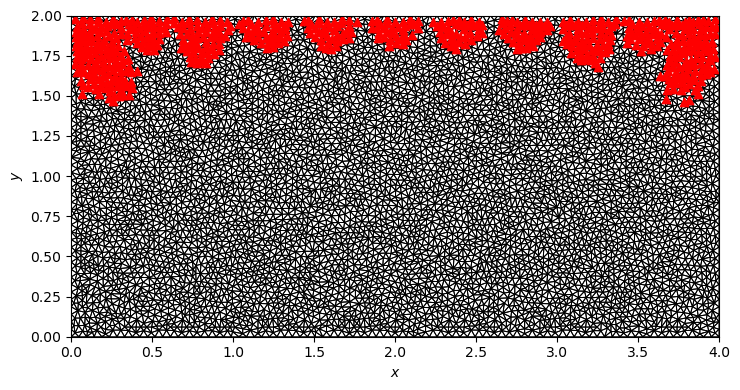

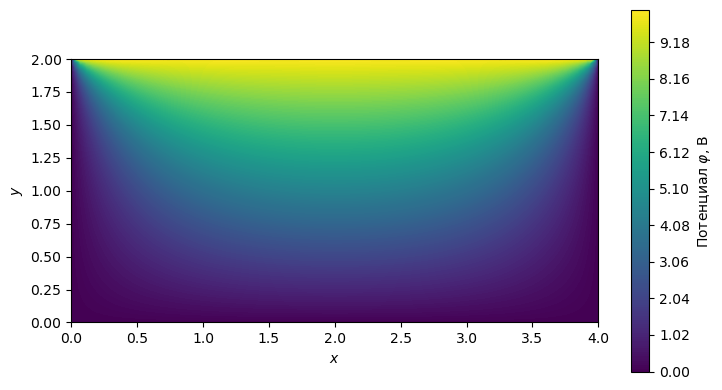

In [46]:
domain_name = "rect_dirichlet_only_0001"

df_x_y = pd.read_csv("./domains/domain_2/mesh0001/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh0001/Test_domain_2_rectangle_dirichlet_only_0001_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh0001/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;


def pr_er(k):
    z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
    #print( round(df_x_y["x"].values[k], 8),  round(df_x_y["y"].values[k], 8))
    print(f"""
        \\hline
        {k}
        & {round(z_exact, 8)}
        & {round(df_z["sol"].values[k], 8)} 
        & {round(np.fabs(z_exact - df_z["sol"].values[k]) , 8)}
        & {round(np.fabs(z_exact - df_z["sol"].values[k]) / z_exact, 8)} \\\\ 
    """)


k = 1000
pr_er(k)

k = 2000
pr_er(k)

k = 3000
pr_er(k)

k = 4000
pr_er(k)

k = 5000
pr_er(k)


print("Number of nodes: ", len(df_x_y.values))
print("Number of elements: ", len(df_elements.values))
print("Mean S: ", mean_square(df_x_y.values, df_elements.values) )
print("Max S: ", max_square(df_x_y.values, df_elements.values) )


print_mean_rel_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
coords_with_high_err = print_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
L2_error(df_x_y.values, df_elements.values, df_z["sol"].values)


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values, 0.7)
plt.scatter(coords_with_high_err[0], coords_with_high_err[1], marker="^", color="red")
plt.axis([0, 4, 0, 2])
# plt.axis('off')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig(export_path + domain_name + "_net.pdf", transparent=False)
plt.show()
plt.close()


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z["sol"].values, levels = 200)

#plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)

plt.axis("image")
plt.colorbar(label = "Потенциал $\\varphi$, В" )
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig(export_path + domain_name + ".png", dpi = 300, transparent=True)
#plt.Axes.set_aspect('equal', adjustable='box', anchor='C')
plt.show()

<h1> 0.001 Calfem


        \hline
        1000
        & 7.01809786
        & 7.0179319 
        & 0.00016596
        & 2.365e-05 \\ 
    

        \hline
        2000
        & 3.09142766
        & 3.09091957 
        & 0.00050809
        & 0.00016436 \\ 
    

        \hline
        3000
        & 2.36605127
        & 2.36557367 
        & 0.0004776
        & 0.00020185 \\ 
    

        \hline
        4000
        & 6.36926022
        & 6.36913706 
        & 0.00012316
        & 1.934e-05 \\ 
    

        \hline
        5000
        & 4.37751466
        & 4.37639743 
        & 0.00111723
        & 0.00025522 \\ 
    
Number of nodes:  5534
Number of elements:  10778
Mean S:  0.00074225
Max S:  0.0009713
Mean rel error:  0.00030776
Mean error:  0.0011
Max error:  0.629 point: (3.9695, 1.9695)
L2_error S: 0.00096066


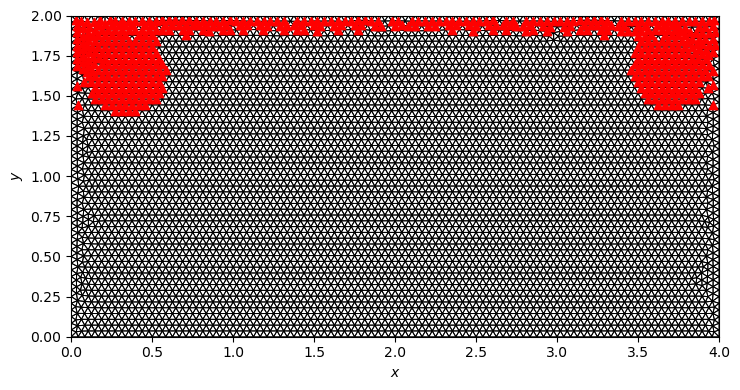

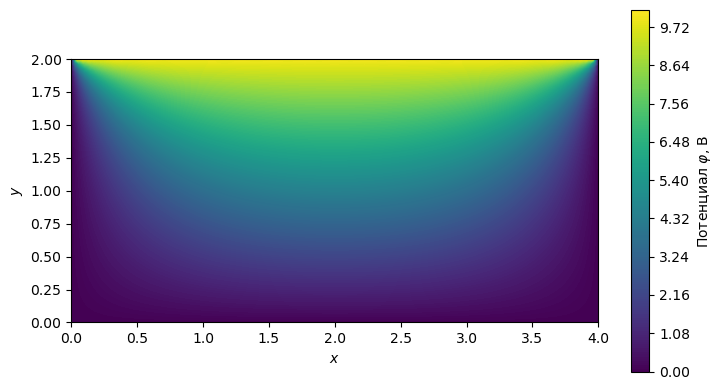

In [47]:
domain_name = "rect_dirichlet_only_0001_calfem"

df_x_y = pd.read_csv("./domains/domain_2/mesh0001_calfem/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh0001_calfem/Test_domain_2_rectangle_dirichlet_only_0001_calfem_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh0001_calfem/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;

def pr_er(k):
    z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
    #print( round(df_x_y["x"].values[k], 8),  round(df_x_y["y"].values[k], 8))
    print(f"""
        \\hline
        {k}
        & {round(z_exact, 8)}
        & {round(df_z["sol"].values[k], 8)} 
        & {round(np.fabs(z_exact - df_z["sol"].values[k]) , 8)}
        & {round(np.fabs(z_exact - df_z["sol"].values[k]) / z_exact, 8)} \\\\ 
    """)


k = 1000
pr_er(k)

k = 2000
pr_er(k)

k = 3000
pr_er(k)

k = 4000
pr_er(k)

k = 5000
pr_er(k)

print("Number of nodes: ", len(df_x_y.values))
print("Number of elements: ", len(df_elements.values))
print("Mean S: ", mean_square(df_x_y.values, df_elements.values) )
print("Max S: ", max_square(df_x_y.values, df_elements.values) )

print_mean_rel_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
coords_with_high_err = print_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
L2_error(df_x_y.values, df_elements.values, df_z["sol"].values)


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values, 0.7)
plt.scatter(coords_with_high_err[0], coords_with_high_err[1], marker="^", color="red")
plt.axis([0, 4, 0, 2])
# plt.axis('off')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig(export_path + domain_name + "_net.pdf", transparent=False)
plt.show()
plt.close()


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z["sol"].values, levels = 200)

#plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)

plt.axis("image")
plt.colorbar(label = "Потенциал $\\varphi$, В" )
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig(export_path + domain_name + ".png", dpi = 300, transparent=True)
#plt.Axes.set_aspect('equal', adjustable='box', anchor='C')
plt.show()

<h1> 0.0005 Calfem


        \hline
        1000
        & 1.2780474
        & 1.27798043 
        & 6.697e-05
        & 5.24e-05 \\ 
    

        \hline
        2000
        & 5.0812708
        & 5.08120305 
        & 6.775e-05
        & 1.333e-05 \\ 
    

        \hline
        3000
        & 2.73939601
        & 2.73933905 
        & 5.696e-05
        & 2.079e-05 \\ 
    

        \hline
        4000
        & 1.08549373
        & 1.08542868 
        & 6.505e-05
        & 5.992e-05 \\ 
    

        \hline
        5000
        & 0.46113557
        & 0.46109779 
        & 3.778e-05
        & 8.193e-05 \\ 
    
Number of nodes:  11270
Number of elements:  22124
Mean S:  0.0003616
Max S:  0.00046798
Mean rel error:  0.00016057
Mean error:  0.00052738
Max error:  0.75448349
L2_error S: 0.00046246


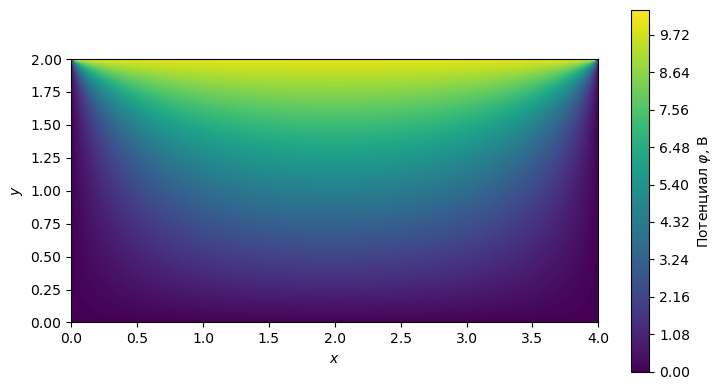

In [10]:
domain_name = "rect_dirichlet_only_00005_calfem"

df_x_y = pd.read_csv("./domains/domain_2/mesh00005_calfem/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh00005_calfem/Test_domain_2_rectangle_dirichlet_only_00005_calfem_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh00005_calfem/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;

def pr_er(k):
    z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
    #print( round(df_x_y["x"].values[k], 8),  round(df_x_y["y"].values[k], 8))
    print(f"""
        \\hline
        {k}
        & {round(z_exact, 8)}
        & {round(df_z["sol"].values[k], 8)} 
        & {round(np.fabs(z_exact - df_z["sol"].values[k]) , 8)}
        & {round(np.fabs(z_exact - df_z["sol"].values[k]) / z_exact, 8)} \\\\ 
    """)


k = 1000
pr_er(k)

k = 2000
pr_er(k)

k = 3000
pr_er(k)

k = 4000
pr_er(k)

k = 5000
pr_er(k)

print("Number of nodes: ", len(df_x_y.values))
print("Number of elements: ", len(df_elements.values))
print("Mean S: ", mean_square(df_x_y.values, df_elements.values) )
print("Max S: ", max_square(df_x_y.values, df_elements.values) )
print_mean_rel_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
print_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
L2_error(df_x_y.values, df_elements.values, df_z["sol"].values)

# plt.rcParams["figure.figsize"] = [7.5, 4]
# plt.rcParams["figure.autolayout"] = True

# plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)
# plt.xlim(0, 4)
# plt.ylim(0, 2)
# plt.axis('off')
# plt.savefig(export_path + domain_name + "_net.pdf", transparent=True)

# plt.show()
# plt.close()


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z["sol"].values, levels = 200)

#plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)

plt.axis("image")
plt.colorbar(label = "Потенциал $\\varphi$, В" )
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig(export_path + domain_name + ".png", dpi = 300, transparent=True)
#plt.Axes.set_aspect('equal', adjustable='box', anchor='C')
plt.show()


        \hline
        1000
        & 2.44440116
        & 2.42089381 
        & 0.02350735
        & 0.00961681 \\ 
    

        \hline
        2000
        & 0.39424798
        & 0.39397865 
        & 0.00026933
        & 0.00068315 \\ 
    

        \hline
        3000
        & 0.69594442
        & 0.69589616 
        & 4.827e-05
        & 6.936e-05 \\ 
    

        \hline
        4000
        & 1.53190778
        & 1.53068773 
        & 0.00122005
        & 0.00079643 \\ 
    

        \hline
        5000
        & 0.96913264
        & 0.96913313 
        & 4.9e-07
        & 5.1e-07 \\ 
    
Number of nodes:  7895
Number of elements:  15502
Mean S:  0.00051606
Max S:  0.0007998
Mean rel error:  0.00052613
Mean error:  0.00154235
Max error:  1.41960957
L2_error S: 0.00466666


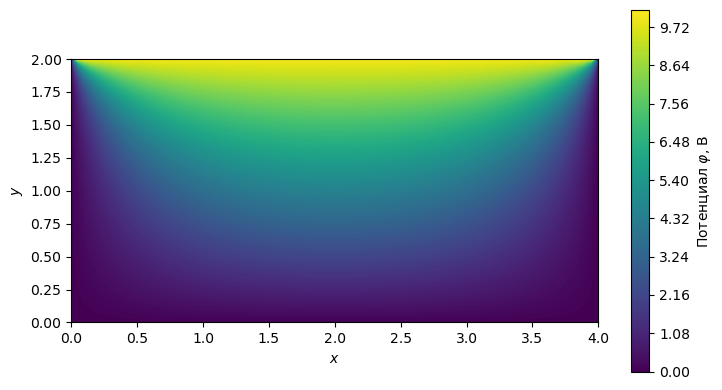

In [11]:
domain_name = "rect_dirichlet_only_00008"

df_x_y = pd.read_csv("./domains/domain_2/mesh00008/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh00008/Test_domain_2_rectangle_dirichlet_only_00008_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh00008/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;

def pr_er(k):
    z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
    #print( round(df_x_y["x"].values[k], 8),  round(df_x_y["y"].values[k], 8))
    print(f"""
        \\hline
        {k}
        & {round(z_exact, 8)}
        & {round(df_z["sol"].values[k], 8)} 
        & {round(np.fabs(z_exact - df_z["sol"].values[k]) , 8)}
        & {round(np.fabs(z_exact - df_z["sol"].values[k]) / z_exact, 8)} \\\\ 
    """)


k = 1000
pr_er(k)

k = 2000
pr_er(k)

k = 3000
pr_er(k)

k = 4000
pr_er(k)

k = 5000
pr_er(k)


print("Number of nodes: ", len(df_x_y.values))
print("Number of elements: ", len(df_elements.values))
print("Mean S: ", mean_square(df_x_y.values, df_elements.values) )
print("Max S: ", max_square(df_x_y.values, df_elements.values) )
print_mean_rel_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
print_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
L2_error(df_x_y.values, df_elements.values, df_z["sol"].values)

plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

# plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)
# plt.xlim(0, 4)
# plt.ylim(0, 2)
# plt.axis('off')
# plt.savefig(export_path + domain_name + "_net.pdf", transparent=True)

plt.show()
plt.close()


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z["sol"].values, levels = 200)

#plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)

plt.axis("image")
plt.colorbar(label = "Потенциал $\\varphi$, В" )
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig(export_path + domain_name + ".png", dpi = 300, transparent=True)
#plt.Axes.set_aspect('equal', adjustable='box', anchor='C')
plt.show()


        \hline
        1000
        & 1.52397364
        & 1.52362181 
        & 0.00035183
        & 0.00023086 \\ 
    

        \hline
        2000
        & 2.49407401
        & 2.49389188 
        & 0.00018213
        & 7.303e-05 \\ 
    

        \hline
        3000
        & 3.40589695
        & 3.40569359 
        & 0.00020336
        & 5.971e-05 \\ 
    

        \hline
        4000
        & 7.40907999
        & 7.40815618 
        & 0.00092381
        & 0.00012469 \\ 
    

        \hline
        5000
        & 8.43166586
        & 8.31131675 
        & 0.12034911
        & 0.01427347 \\ 
    
Number of nodes:  5151
Number of elements:  10000
Mean S:  0.0008
Max S:  0.0008
Mean rel error:  0.00046586
Mean error:  0.00186589
Max error:  0.13483264
L2_error S: 0.00041789


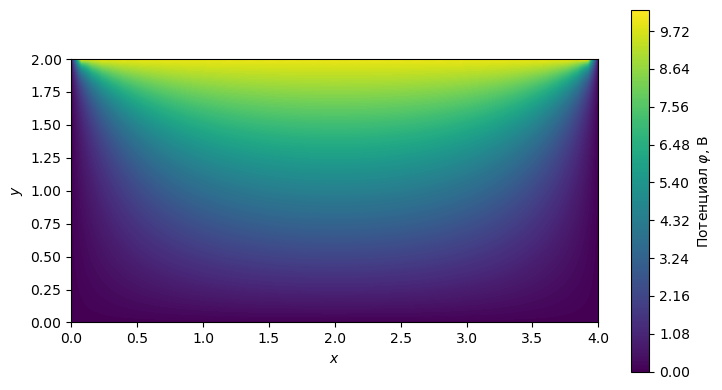

In [12]:
domain_name = "rect_dirichlet_only_00008_s"

df_x_y = pd.read_csv("./domains/domain_2/mesh00008_s/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh00008_s/Test_domain_2_rectangle_dirichlet_only_00008_s_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh00008_s/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;

def pr_er(k):
    z_exact = exact_solution(df_x_y["x"].values[k], df_x_y["y"].values[k])
    #print( round(df_x_y["x"].values[k], 8),  round(df_x_y["y"].values[k], 8))
    print(f"""
        \\hline
        {k}
        & {round(z_exact, 8)}
        & {round(df_z["sol"].values[k], 8)} 
        & {round(np.fabs(z_exact - df_z["sol"].values[k]) , 8)}
        & {round(np.fabs(z_exact - df_z["sol"].values[k]) / z_exact, 8)} \\\\ 
    """)


k = 1000
pr_er(k)

k = 2000
pr_er(k)

k = 3000
pr_er(k)

k = 4000
pr_er(k)

k = 5000
pr_er(k)


print("Number of nodes: ", len(df_x_y.values))
print("Number of elements: ", len(df_elements.values))
print("Mean S: ", mean_square(df_x_y.values, df_elements.values) )
print("Max S: ", max_square(df_x_y.values, df_elements.values) )
print_mean_rel_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
print_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)
L2_error(df_x_y.values, df_elements.values, df_z["sol"].values)

plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

# plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)
# plt.xlim(0, 4)
# plt.ylim(0, 2)
# plt.axis('off')
# plt.savefig(export_path + domain_name + "_net.pdf", transparent=True)

plt.show()
plt.close()


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z["sol"].values, levels = 200)

#plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)

plt.axis("image")
plt.colorbar(label = "Потенциал $\\varphi$, В" )
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig(export_path + domain_name + ".png", dpi = 300, transparent=True)
#plt.Axes.set_aspect('equal', adjustable='box', anchor='C')
plt.show()